## Author

**Full Name: Yiğit Yalın**

**Student ID: 22002178**

### Import the required libraries

In [1]:
from collections import namedtuple
from enum import IntEnum
from tabulate import tabulate
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

np.set_printoptions(precision=5)

## Enumerate the actions

In [2]:
class Actions(IntEnum):
    GRAB = 0
    DRY = 1
    STORE = 2
    
    def __str__(self):
        return "A" + str(self.value)

## Enumerate the states

In [3]:
class States(IntEnum):
    NOT_HOLDING_CUPS = 0
    HOLDING_A_WET_CUP = 1
    HOLDING_A_DRY_CUP = 2
    JOB_DONE = 3
    
    def __str__(self):
        return "S" + str(self.value)
    
    @staticmethod
    def is_terminal(state):
        return state == States.JOB_DONE
    
    @staticmethod
    def get_nonterminal():
        return [state for state in States if not States.is_terminal(state)]
    
    @staticmethod
    def get_possible_actions(state):
        if States.is_terminal(state):
            return [Actions.STORE]
        elif state == States.NOT_HOLDING_CUPS:
            return [Actions.GRAB]
        else:
            return list(Actions)

## Model the environment

The following graph includes the possible actions for each state and associated rewards. Then, we will construct the one-step transition and reward matrices.

In [4]:
class StateActionPair(namedtuple('StateActionPair', ['state', 'action'])):
    __slots__ = ()
    
    def __str__(self):
        return str(self.action)
    
    def __int__(self):
        return int(self.action)

In [5]:
G = nx.DiGraph()

edges = [
    (
        States.NOT_HOLDING_CUPS, 
        StateActionPair(States.NOT_HOLDING_CUPS, Actions.GRAB), 
        dict(reward=0)
    ),
    (
        States.HOLDING_A_WET_CUP, 
        StateActionPair(States.HOLDING_A_WET_CUP, Actions.GRAB), 
        dict(reward=-20)
    ),
    (
        States.HOLDING_A_WET_CUP, 
        StateActionPair(States.HOLDING_A_WET_CUP, Actions.DRY),
        dict(reward=0)
    ),
    (
        States.HOLDING_A_WET_CUP, 
        StateActionPair(States.HOLDING_A_WET_CUP, Actions.STORE), 
        dict(reward=5)
    ),
    (
        States.HOLDING_A_DRY_CUP, 
        StateActionPair(States.HOLDING_A_DRY_CUP, Actions.GRAB),
        dict(reward=-20)
    ),
    (
        States.HOLDING_A_DRY_CUP, 
        StateActionPair(States.HOLDING_A_DRY_CUP, Actions.DRY), 
        dict(reward=0)
    ),
    (
        States.HOLDING_A_DRY_CUP, 
        StateActionPair(States.HOLDING_A_DRY_CUP, Actions.STORE),
        dict(reward=10)
    ),
    (
        StateActionPair(States.NOT_HOLDING_CUPS, Actions.GRAB),
        States.HOLDING_A_WET_CUP,
        dict(reward=0)
    ),
    (
        StateActionPair(States.HOLDING_A_WET_CUP, Actions.GRAB),
        States.HOLDING_A_WET_CUP,
        dict(reward=0)
    ),
    (
        StateActionPair(States.HOLDING_A_WET_CUP, Actions.DRY),
        States.HOLDING_A_DRY_CUP,
        dict(reward=0)
    ),
    (
        StateActionPair(States.HOLDING_A_WET_CUP, Actions.DRY),
        States.NOT_HOLDING_CUPS,
        dict(reward=-20)
    ),
    (
        StateActionPair(States.HOLDING_A_WET_CUP, Actions.STORE),
        States.JOB_DONE,
        dict(reward=0)
    ),
    (
        StateActionPair(States.HOLDING_A_DRY_CUP, Actions.GRAB),
        States.HOLDING_A_WET_CUP,
        dict(reward=0)
    ),
    (
        StateActionPair(States.HOLDING_A_DRY_CUP, Actions.DRY),
        States.NOT_HOLDING_CUPS,
        dict(reward=-20)
    ),
    (
        StateActionPair(States.HOLDING_A_DRY_CUP, Actions.DRY),
        States.HOLDING_A_DRY_CUP,
        dict(reward=0)
    ),
    (
        StateActionPair(States.HOLDING_A_DRY_CUP, Actions.STORE),
        States.JOB_DONE,
        dict(reward=0)
    )
]

G.add_edges_from(edges)

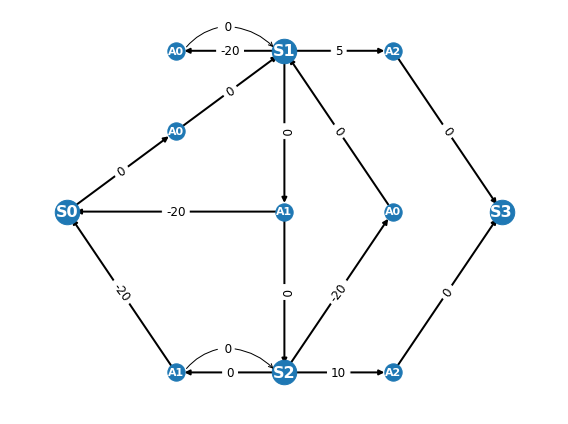

In [6]:
positions = {
    States.NOT_HOLDING_CUPS: np.array([0, 0]),
    States.HOLDING_A_WET_CUP: np.array([20, 10]),
    States.HOLDING_A_DRY_CUP: np.array([20, -10]),
    States.JOB_DONE: np.array([40, 0]),
    StateActionPair(States.NOT_HOLDING_CUPS, Actions.GRAB): np.array([10, 5]),
    StateActionPair(States.HOLDING_A_WET_CUP, Actions.GRAB): np.array([10, 10]),
    StateActionPair(States.HOLDING_A_WET_CUP, Actions.STORE): np.array([30, 10]),
    StateActionPair(States.HOLDING_A_WET_CUP, Actions.DRY): np.array([20, 0]),
    StateActionPair(States.HOLDING_A_DRY_CUP, Actions.GRAB): np.array([30, 0]),
    StateActionPair(States.HOLDING_A_DRY_CUP, Actions.DRY): np.array([10, -10]),
    StateActionPair(States.HOLDING_A_DRY_CUP, Actions.STORE): np.array([30, -10])
}

state_nodes = set(States)
action_nodes = set(G.nodes()) - state_nodes
nx.draw_networkx_nodes(G, positions, nodelist=state_nodes, node_size=600)
nx.draw_networkx_nodes(G, positions, nodelist=action_nodes, node_size=300)

nx.draw_networkx_labels(G, positions, labels={node: node for node in state_nodes},
                        font_size=16, font_color='white', font_weight='bold')
nx.draw_networkx_labels(G, positions, labels={node: node for node in action_nodes},
                        font_size=11, font_color='white', font_weight='bold')

edges_loop = set([
    (
        StateActionPair(States.HOLDING_A_WET_CUP, Actions.GRAB),
        States.HOLDING_A_WET_CUP,
    ),
    (
        StateActionPair(States.HOLDING_A_DRY_CUP, Actions.DRY),
        States.HOLDING_A_DRY_CUP,
    )
])
nx.draw_networkx_edges(G, positions, edgelist=set(G.edges()) - edges_loop, width=2)
edge_labels = nx.get_edge_attributes(G, "reward")

ax = plt.gca()
for edge in edges_loop:
    edge_labels.pop(edge)
    arrow_position = positions[edge[1]] - np.array([0.7, 0])
    start_position = positions[edge[0]] + np.array([0.7, 0])
    reward_position = (arrow_position + start_position) / 2 + np.array([0, 1.5])
    reward = G.get_edge_data(edge[0], edge[1]).get("reward")
    correction = np.array([reward * 0.05 - 1.6, 0])
    
    ax.annotate(
        '   ' + str(reward),
        xy=start_position, xycoords='data', 
        xytext=reward_position + correction, textcoords='data',
        arrowprops=dict(
            arrowstyle="-", color="0",
            shrinkA=5, shrinkB=5,
            patchA=None, patchB=None,
            connectionstyle=f"arc3,rad={0.2}"
        ),
        verticalalignment='center', fontsize=12
    )
    ax.annotate(
        '',
        xy=arrow_position, xycoords='data',
        xytext=reward_position, textcoords='data',
        arrowprops=dict(
            arrowstyle="->", color="0",
            shrinkA=5, shrinkB=5,
            patchA=None, patchB=None,
            connectionstyle=f"arc3,rad={-0.2}"
        ),
    )


nx.draw_networkx_edge_labels(G, positions, edge_labels, font_size=12)

ax.margins(0.08)

fig = ax.get_figure()
fig.set_size_inches(8, 6)

plt.axis("off")
plt.tight_layout()
plt.show()

### Construct the one-step probability matrices for each action

In [7]:
P_grab = np.array([
    [0, 1, 0, 0],
    [0, 1, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1]
])

print(P_grab)

[[0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]]


In [8]:
P_dry = np.array([
    [1, 0, 0, 0],
    [0.1, 0, 0.9, 0],
    [0.1, 0, 0.9, 0],
    [0, 0, 0, 1]
])

print(P_dry)

[[1.  0.  0.  0. ]
 [0.1 0.  0.9 0. ]
 [0.1 0.  0.9 0. ]
 [0.  0.  0.  1. ]]


In [9]:
P_store = np.array([
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 1]
])

print(P_store)

[[1 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]


In [10]:
P = np.concatenate(
    [P_grab[np.newaxis, ...], P_dry[np.newaxis, ...], P_store[np.newaxis, ...]], 
    axis=0
)

for action in Actions:
    print(f'One-step transition matrix for the action "{action.name}":', P[action], 
          sep='\n', end='\n\n')

One-step transition matrix for the action "GRAB":
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]

One-step transition matrix for the action "DRY":
[[1.  0.  0.  0. ]
 [0.1 0.  0.9 0. ]
 [0.1 0.  0.9 0. ]
 [0.  0.  0.  1. ]]

One-step transition matrix for the action "STORE":
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]



### Construct the reward vector for each action

In [11]:
R_s2a = np.zeros((len(Actions), len(States)))
                  
for action in Actions:
    for state in States:
        R_s2a[action][state] = G.get_edge_data(
            state, StateActionPair(state, action), default={}
        ).get('reward', 0)
            
            
print(R_s2a)

[[  0. -20. -20.   0.]
 [  0.   0.   0.   0.]
 [  0.   5.  10.   0.]]


In [12]:
R_a2s = np.zeros((len(Actions), len(States), len(States)))

for action in Actions:
    for u in States:
        for v, data in dict(
            G.adj.get(StateActionPair(u, action), default={})
        ).items():
            R_a2s[action][u][v] = data.get('reward', 0)
            
            
print(R_a2s)

[[[  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]]

 [[  0.   0.   0.   0.]
  [-20.   0.   0.   0.]
  [-20.   0.   0.   0.]
  [  0.   0.   0.   0.]]

 [[  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]
  [  0.   0.   0.   0.]]]


## Define the Policy Evaluation function

In [13]:
def evaluate_policy(pi, gamma, epsilon=0, max_iterations=1000):
    v = np.zeros(len(States))
    
    for _ in range(max_iterations):
        v_new = np.zeros(len(States))
        for state in States:
            for action in Actions:
                s = 0
                reward = R_s2a[action][state]
                for next_state in States:
                    p = P[action][state][next_state]
                    s += p * v[next_state]
                    reward += p * R_a2s[action][state][next_state]
                v_new[state] += pi[action][state] * (reward + gamma * s)
                
        if epsilon and np.max(np.abs(v_new - v)) < epsilon:
            break
            
        v = v_new
    return v_new

## Apply Policy Iteration algorithm to find the optimal policy

### Initialize the policy

In [14]:
pi = np.array([
    np.ones(len(States)) if action is Actions.GRAB else np.zeros(len(States))
    for action in Actions
])

print(pi)

[[1. 1. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [15]:
gamma = 1
epsilon = 1e-5
max_iterations = 10000
state_values_policy_iteration = [evaluate_policy(pi, gamma)]


for iteration in tqdm(range(1, max_iterations + 1)):
    pi_stable = True
    v = evaluate_policy(pi, gamma, epsilon)
    
    for state in States:
        values = np.zeros(len(Actions))
        
        for action in Actions:
            s = 0
            reward = R_s2a[action][state]
            for next_state in States:
                p = P[action][state][next_state]
                s += p * v[next_state]
                reward += p * R_a2s[action][state][next_state]
            
            values[action] += reward + gamma * s
            
        best_action = values.argmax()
        policy_action = pi.transpose()[state].argmax()
        
        if best_action != policy_action:
            pi_stable = False
            
        pi[..., state] = np.identity(len(Actions))[best_action]
        
    if pi_stable:
        break
    
    state_values_policy_iteration.append(evaluate_policy(pi, gamma))
    
    print("\nIteration: " + str(iteration))
    print(tabulate(zip(
        map(lambda s: s.name, States), 
        state_values_policy_iteration[-1],
        (Actions(values.argmax()).name if not States.is_terminal(state) else "NA"
         for state, values in enumerate(pi.transpose()))
    ), headers=["State", "Value", "Action"], tablefmt="fancy_grid"))

  0%|          | 0/10000 [00:00<?, ?it/s]


Iteration: 1
╒═══════════════════╤═════════╤══════════╕
│ State             │   Value │ Action   │
╞═══════════════════╪═════════╪══════════╡
│ NOT_HOLDING_CUPS  │       0 │ DRY      │
├───────────────────┼─────────┼──────────┤
│ HOLDING_A_WET_CUP │       5 │ STORE    │
├───────────────────┼─────────┼──────────┤
│ HOLDING_A_DRY_CUP │      10 │ STORE    │
├───────────────────┼─────────┼──────────┤
│ JOB_DONE          │       0 │ NA       │
╘═══════════════════╧═════════╧══════════╛

Iteration: 2
╒═══════════════════╤══════════╤══════════╕
│ State             │    Value │ Action   │
╞═══════════════════╪══════════╪══════════╡
│ NOT_HOLDING_CUPS  │  7.77778 │ GRAB     │
├───────────────────┼──────────┼──────────┤
│ HOLDING_A_WET_CUP │  7.77778 │ DRY      │
├───────────────────┼──────────┼──────────┤
│ HOLDING_A_DRY_CUP │ 10       │ STORE    │
├───────────────────┼──────────┼──────────┤
│ JOB_DONE          │  0       │ NA       │
╘═══════════════════╧══════════╧══════════╛


## Apply Value Iteration algorithm to find the optimal policy

In [16]:
gamma = 1
epsilon = 1e-5
v = np.zeros(len(States))
max_iterations = 10000
best_actions = []
state_values_value_iteration = [v.copy()]


for iteration in tqdm(range(1, max_iterations + 1)):
    delta = 0
    best_actions.append([])
    for state in States:
        values = np.zeros(len(Actions))
        for action in Actions:
            s = 0
            reward = R_s2a[action][state]
            for next_state in States:
                p = P[action][state][next_state]
                s += p * v[next_state]
                reward += p * R_a2s[action][state][next_state]
                
            values[action] = reward + gamma * s
        
        delta = max(delta, np.abs(values.max() - v[state]))
        best_actions[iteration - 1].append(values.argmax())
        v[state] = values.max()
    
    if delta < epsilon:
        break
        
    state_values_value_iteration.append(v.copy())
    
    print("\nIteration: " + str(iteration))
    print(tabulate(zip(
        map(lambda state: state.name, States), 
        v, 
        (Actions(action).name if not States.is_terminal(state) else "NA"
         for state, action in enumerate(best_actions[-1]))
    ), headers=["State", "Value", "Best Action"], tablefmt="fancy_grid"))

  0%|          | 0/10000 [00:00<?, ?it/s]


Iteration: 1
╒═══════════════════╤═════════╤═══════════════╕
│ State             │   Value │ Best Action   │
╞═══════════════════╪═════════╪═══════════════╡
│ NOT_HOLDING_CUPS  │       0 │ GRAB          │
├───────────────────┼─────────┼───────────────┤
│ HOLDING_A_WET_CUP │       5 │ STORE         │
├───────────────────┼─────────┼───────────────┤
│ HOLDING_A_DRY_CUP │      10 │ STORE         │
├───────────────────┼─────────┼───────────────┤
│ JOB_DONE          │       0 │ NA            │
╘═══════════════════╧═════════╧═══════════════╛

Iteration: 2
╒═══════════════════╤═════════╤═══════════════╕
│ State             │   Value │ Best Action   │
╞═══════════════════╪═════════╪═══════════════╡
│ NOT_HOLDING_CUPS  │     5   │ GRAB          │
├───────────────────┼─────────┼───────────────┤
│ HOLDING_A_WET_CUP │     7.5 │ DRY           │
├───────────────────┼─────────┼───────────────┤
│ HOLDING_A_DRY_CUP │    10   │ STORE         │
├───────────────────┼─────────┼───────────────┤
│ JOB_DONE  

## Apply First Visit Monte Carlo algorithm to find the optimal policy

### Define $\epsilon$-greedy policy and $\epsilon$ decay schedule

In [17]:
def epsilon_decay_schedule(episode):
    if episode < 10000:
        return 1 - episode / 20000
    else:
        return (1 - 10000 / 20000) / (1 + episode - 10000)
    
def epsilon_greedy_policy(state, q_values, epsilon):
    possible_actions = States.get_possible_actions(state)
    if not possible_actions:
        return Actions.STORE
    if np.random.rand() < epsilon:
        return np.random.choice(possible_actions)
    else:
        return np.argmax(q_values[state][possible_actions])

### Define the learning rate

In [18]:
def alpha(state, action, n_occurences):
    return 80 / (80 + n_occurences[state][action])

In [19]:
def play_one_step(state, action):
    next_state = np.random.choice(States, p=P[action][state])
    reward = R_s2a[action][state] + R_a2s[action][state][next_state]
    return next_state, reward

In [20]:
gamma = 1
max_episode_steps = 10
max_iterations = 1_000_000
n_occurences = np.zeros((len(States), len(Actions)))
q_values = np.zeros((len(States), len(Actions)))
q_values_mc = [q_values.copy()]

for iteration in tqdm(range(1, max_iterations + 1)):
    episode = []
    delta = 0
    state = States.NOT_HOLDING_CUPS
    epsilon = epsilon_decay_schedule(iteration)
    
    while not States.is_terminal(state):
        action = epsilon_greedy_policy(state, q_values, epsilon)
        next_state, reward = play_one_step(state, action)
        episode.append((state, action, reward))
        state = next_state
        if len(episode) > max_episode_steps:
            break
    
    first_occurences = np.full(len(States.get_nonterminal()), -1)
    for index, (state, action, _) in enumerate(episode):
        if first_occurences[state] == -1:
            n_occurences[state][action] += 1
            first_occurences[state] = index
        
        if -1 not in first_occurences:
            break
    
    for state in States.get_nonterminal():
        if first_occurences[state] == -1:
            continue
            
        action = episode[first_occurences[state]][1]
        g = np.sum([
            reward * (gamma ** index)
            for index, (_, _, reward) in enumerate(episode[first_occurences[state]:])
        ])
        q_values[state][action] += alpha(state, action, n_occurences)\
                                   * (g - q_values[state][action])

    q_values_mc.append(q_values.copy())

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [21]:
print("Values:")
print(tabulate(zip(
    map(lambda state: state.name, States), 
    q_values_mc[-1].max(axis=-1), 
    (Actions(action).name if not States.is_terminal(state) else "NA"
     for state, action in enumerate(q_values_mc[-1].argmax(axis=-1)))
), headers=["State", "Value", "Best Action"], tablefmt="fancy_grid"))

Values:
╒═══════════════════╤══════════╤═══════════════╕
│ State             │    Value │ Best Action   │
╞═══════════════════╪══════════╪═══════════════╡
│ NOT_HOLDING_CUPS  │  7.38079 │ GRAB          │
├───────────────────┼──────────┼───────────────┤
│ HOLDING_A_WET_CUP │  7.55382 │ DRY           │
├───────────────────┼──────────┼───────────────┤
│ HOLDING_A_DRY_CUP │ 10       │ STORE         │
├───────────────────┼──────────┼───────────────┤
│ JOB_DONE          │  0       │ NA            │
╘═══════════════════╧══════════╧═══════════════╛


## Apply SARSA algorithm to find the optimal policy

### Define the learning rate schedule

In [22]:
def alpha(state, action, n_occurences):
    return 100 / (100 + n_occurences[state][action])

In [23]:
def play_one_step(state, action):
    next_state = np.random.choice(States, p=P[action][state])
    reward = R_s2a[action][state] + R_a2s[action][state][next_state]
    return next_state, reward

In [24]:
def epsilon_decay_schedule(episode):
    if episode < 50000:
        return 1 - episode / 100000
    else:
        return (1 - 50000 / 100000) / np.log2(2 + episode - 50000)
    
def epsilon_greedy_policy(state, q_values, epsilon):
    possible_actions = States.get_possible_actions(state)
    if not possible_actions:
        return Actions.STORE
    if np.random.rand() < epsilon:
        return np.random.choice(possible_actions)
    else:
        return np.argmax(q_values[state][possible_actions])

In [25]:
gamma = 1
max_episode_steps = 10
max_iterations = 1_000_000
n_occurences = np.zeros((len(States), len(Actions)))
q_values = np.zeros((len(States), len(Actions)))
q_values_sarsa = [q_values.copy()]


for iteration in tqdm(range(1, max_iterations + 1)):
    state = States.NOT_HOLDING_CUPS
    epsilon = epsilon_decay_schedule(iteration)
    
    while not States.is_terminal(state):
        action = epsilon_greedy_policy(state, q_values, epsilon)
        next_state, reward = play_one_step(state, action)
        next_action = epsilon_greedy_policy(next_state, q_values, epsilon)

        td = reward + gamma * q_values[next_state][next_action]\
             - q_values[state][action]
        q_values[state, action] += alpha(state, action, n_occurences) * td
        
        n_occurences[state][action] += 1
        state = next_state
        
        if len(episode) > max_episode_steps:
            break
            
    q_values_sarsa.append(q_values.copy())

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [26]:
print("Values:")
print(tabulate(zip(
    map(lambda state: state.name, States), 
    q_values_sarsa[-1].max(axis=-1), 
    (Actions(action).name if not States.is_terminal(state) else "NA"
     for state, action in enumerate(q_values_sarsa[-1].argmax(axis=-1)))
), headers=["State", "Value", "Best Action"], tablefmt="fancy_grid"))

Values:
╒═══════════════════╤══════════╤═══════════════╕
│ State             │    Value │ Best Action   │
╞═══════════════════╪══════════╪═══════════════╡
│ NOT_HOLDING_CUPS  │  7.42767 │ GRAB          │
├───────────────────┼──────────┼───────────────┤
│ HOLDING_A_WET_CUP │  7.62917 │ DRY           │
├───────────────────┼──────────┼───────────────┤
│ HOLDING_A_DRY_CUP │ 10       │ STORE         │
├───────────────────┼──────────┼───────────────┤
│ JOB_DONE          │  0       │ NA            │
╘═══════════════════╧══════════╧═══════════════╛


## Apply Q-learning algorithm to find the optimal policy

In [27]:
def alpha(state, action, n_occurences):
    return 40 / (40 + n_occurences[state][action])

In [28]:
def play_one_step(state, action):
    next_state = np.random.choice(States, p=P[action][state])
    reward = R_s2a[action][state] + R_a2s[action][state][next_state]
    return next_state, reward

In [29]:
def epsilon_decay_schedule(episode):
    if episode < 50000:
        return 1 - episode / 100000
    else:
        return (1 - 50000 / 100000) / np.log2(2 + episode - 50000)
    
def epsilon_greedy_policy(state, q_values, epsilon):
    possible_actions = States.get_possible_actions(state)
    if np.random.rand() < epsilon:
        return np.random.choice(possible_actions)
    else:
        return np.argmax(q_values[state][possible_actions])

In [30]:
gamma = 1
max_episode_steps = 10
max_iterations = 1_000_000
n_occurences = np.zeros((len(States), len(Actions)))
q_values = np.zeros((len(States), len(Actions)))
q_values_q_learning = [q_values.copy()]


for iteration in tqdm(range(1, max_iterations + 1)):
    state = States.NOT_HOLDING_CUPS
    epsilon = epsilon_decay_schedule(iteration)
    
    while not States.is_terminal(state):
        action = epsilon_greedy_policy(state, q_values, epsilon)
        next_state, reward = play_one_step(state, action)
        
        possible_actions = States.get_possible_actions(next_state)
        td = reward + gamma * q_values[next_state][possible_actions].max()\
             - q_values[state][action]
        q_values[state, action] += alpha(state, action, n_occurences) * td
        
        n_occurences[state][action] += 1
        state = next_state
        
        if len(episode) > max_episode_steps:
            break
            
    
    q_values_q_learning.append(q_values.copy())

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [31]:
print("Values:")
print(tabulate(zip(
    map(lambda state: state.name, States), 
    q_values_q_learning[-1].max(axis=-1), 
    (Actions(action).name if not States.is_terminal(state) else "NA"
     for state, action in enumerate(q_values_q_learning[-1].argmax(axis=-1)))
), headers=["State", "Value", "Best Action"], tablefmt="fancy_grid"))

Values:
╒═══════════════════╤══════════╤═══════════════╕
│ State             │    Value │ Best Action   │
╞═══════════════════╪══════════╪═══════════════╡
│ NOT_HOLDING_CUPS  │  7.7606  │ GRAB          │
├───────────────────┼──────────┼───────────────┤
│ HOLDING_A_WET_CUP │  7.74474 │ DRY           │
├───────────────────┼──────────┼───────────────┤
│ HOLDING_A_DRY_CUP │ 10       │ STORE         │
├───────────────────┼──────────┼───────────────┤
│ JOB_DONE          │  0       │ NA            │
╘═══════════════════╧══════════╧═══════════════╛


## Comparison of the algorithms

We can easily observe that policy iteration is the algorithm that takes the least iteration to converge with 3 iterations, and the value iteration algorithm follows it with 8 iterations. Therefore, we will leave them out of the following discussion.


The other algorithms will take many iterations to converge, and they might not converge in limited number of iterations. Thus, we will observe the convergence of values using plots. We will try to see that the values will approach or oscillate around the optimal values.

In [32]:
def plot_best_q_values(q_values, title):
    q_values = np.array(q_values)
    plt.figure()
    plt.title(title)
    for state in States.get_nonterminal():
        plt.plot(q_values[..., state].max(axis=-1), label=state.name)
    plt.legend()
    plt.show()

Let's start with plotting the Q values as a function of episodes.

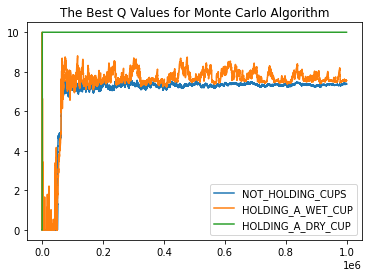

In [33]:
plot_best_q_values(q_values_mc, title='The Best Q Values for Monte Carlo Algorithm')

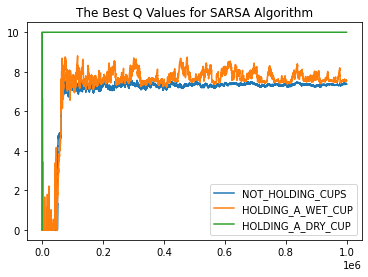

In [34]:
plot_best_q_values(q_values_mc, title='The Best Q Values for SARSA Algorithm')

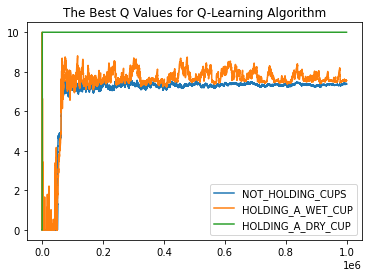

In [35]:
plot_best_q_values(q_values_mc, title='The Best Q Values for Q-Learning Algorithm')

Recall that the best Q values for states are 7.77778, 7.77778 and 10, respectively, as we found in policy and value iterations. We can try to observe that the difference between the true Q values and the results the algorithms approaches to 0

In [36]:
best_q_values = [7.77778, 7.77778, 10, 0]

In [37]:
def plot_residuals(q_values, best_q_values, title):
    q_values = np.array(q_values)
    plt.figure()
    plt.title(title)
    for state in States.get_nonterminal():
        plt.plot(q_values[..., state].max(axis=-1) - best_q_values[state], 
                 label=state.name)
    plt.legend()
    plt.show()

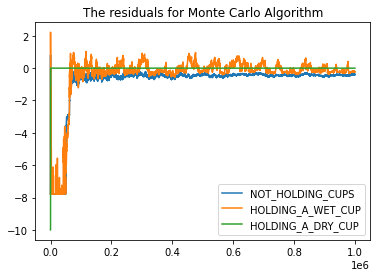

In [38]:
plot_residuals(q_values_mc, best_q_values, 'The residuals for Monte Carlo Algorithm')

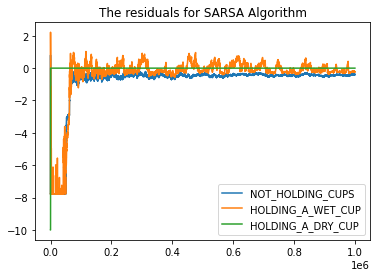

In [39]:
plot_residuals(q_values_mc, best_q_values, 'The residuals for SARSA Algorithm')

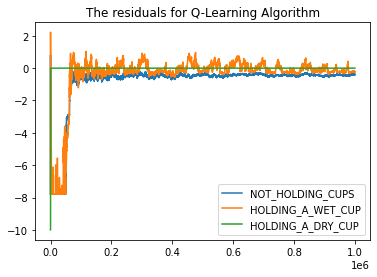

In [40]:
plot_residuals(q_values_mc, best_q_values, 'The residuals for Q-Learning Algorithm')

We can observe that the results of the algorithms approach to the true Q-values. Note that with fine-tuned $\epsilon$ schedule, policy and learning rate, it is possible to converge faster.

Let's now see which one got the optimal policy faster. We will consider the first step after which the argmax of the Q values gives the optimal actions for each state.

In [41]:
optimal_policy = [Actions.GRAB, Actions.DRY, Actions.STORE, 0]

In [42]:
def get_n_episodes_for_optimal_policy(q_values):
    for episode in range(len(q_values) - 1, 0, -1):
        optimal = [state.argmax() for state in q_values[episode]] == optimal_policy
        if not optimal:
            break
    
    return episode + 1

In [43]:
optimal_mc = get_n_episodes_for_optimal_policy(q_values_mc)
optimal_sarsa = get_n_episodes_for_optimal_policy(q_values_sarsa)
optimal_q = get_n_episodes_for_optimal_policy(q_values_q_learning)

In [44]:
print('The number of episodes to obtain the optimal policy:')
print(tabulate([
    ['First Visit Monte Carlo', 'SARSA', 'Q Learning'],
    [optimal_mc, optimal_sarsa, optimal_q]
], tablefmt="fancy_grid"))

The number of episodes to obtain the optimal policy:
╒═════════════════════════╤═══════╤════════════╕
│ First Visit Monte Carlo │ SARSA │ Q Learning │
├─────────────────────────┼───────┼────────────┤
│ 62089                   │ 70435 │ 916        │
╘═════════════════════════╧═══════╧════════════╛


We can observe that the Q-Learning algorithm significantly outperforms the other two algorithms, and the SARSA algorithm is the slowest one to converge to the optimal policy after First Visit Monte Carlo.

Since we did not iterate enough to obtain the optimal Q values, we do not know which one of these algorithms will converge to the optimal values. However, by comparing the Q values produces by the algorithms in their last iterations, we can say that the Q-Learning algortihm has the closest values to the optimal ones.

## Which of the above methods should I use to find an optimal policy if I didn’t know the probability of breaking cups during drying?

If we did not know the transition probabilities, we would need a model-free algorithms. This means that we cannot use value iteration and policy iteration algorithms. Thus, the best option would be the Q-Learning algorithm since we observed that the Q-Learning algorithm converged to the optimal policy faster than the other two model-free algorithms.

## What is the effect of increasing ε while using an ε-greedy algorithm?

The $\epsilon$ in an $\epsilon$-greedy policy determines the probability of choosing a random action instead of the one with the highest Q-value. In other words, the $\epsilon$ value is the probability of exploring other actions instead of exploiting our current knowledge. We thus can obtain a better solution that we do not currently know. If we increase the $\epsilon$ while using an $\epsilon$-greedy algorithm, we increase the probability of choosing a random action and exploring other options.